In [1]:
import numpy as np
import pyaudio as pa
import os, time

In [2]:
import nemo
import nemo.collections.asr as nemo_asr


[NeMo W 2022-01-23 12:47:44 optimizers:52] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-01-23 12:47:49 experimental:27] Module <function get_argmin_mat at 0x148b3b160> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-01-23 12:47:49 experimental:27] Module <function getMultiScaleCosAffinityMatrix at 0x148b3b1f0> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-01-23 12:47:49 experimental:27] Module <function parse_scale_configs at 0x148b3bd30> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-01-23 12:47:49 experimental:27] Module <function get_embs_and_timestamps at 0x148b3bdc0> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [3]:
# sample rate, Hz
SAMPLE_RATE = 16000
import torch
print(nemo.__version__)

1.6.0rc0


## Restore the model from NGC

In [4]:
asr_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En", strict=False)

[NeMo I 2022-01-23 12:47:50 cloud:56] Found existing object /Users/sorenmadsen/.cache/torch/NeMo/NeMo_1.6.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-01-23 12:47:50 cloud:62] Re-using file from: /Users/sorenmadsen/.cache/torch/NeMo/NeMo_1.6.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-01-23 12:47:50 common:729] Instantiating model from pre-trained checkpoint
[NeMo I 2022-01-23 12:47:52 features:264] PADDING: 16
[NeMo I 2022-01-23 12:47:52 features:281] STFT using torch
[NeMo I 2022-01-23 12:47:53 save_restore_connector:149] Model EncDecCTCModel was successfully restored from /Users/sorenmadsen/.cache/torch/NeMo/NeMo_1.6.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


## Observing the config of the model

In [5]:
from omegaconf import OmegaConf
import copy

In [35]:
# Preserve a copy of the full config
cfg = copy.deepcopy(asr_model._cfg)
print(OmegaConf.to_yaml(cfg))

preprocessor:
  _target_: nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor
  normalize: per_feature
  window_size: 0.02
  sample_rate: 16000
  window_stride: 0.01
  window: hann
  features: 64
  n_fft: 512
  frame_splicing: 1
  dither: 1.0e-05
  stft_conv: false
spec_augment:
  _target_: nemo.collections.asr.modules.SpectrogramAugmentation
  rect_freq: 50
  rect_masks: 5
  rect_time: 120
encoder:
  _target_: nemo.collections.asr.modules.ConvASREncoder
  feat_in: 64
  activation: relu
  conv_mask: true
  jasper:
  - filters: 256
    repeat: 1
    kernel:
    - 33
    stride:
    - 2
    dilation:
    - 1
    dropout: 0.0
    residual: false
    separable: true
  - filters: 256
    repeat: 5
    kernel:
    - 33
    stride:
    - 1
    dilation:
    - 1
    dropout: 0.0
    residual: true
    separable: true
  - filters: 256
    repeat: 5
    kernel:
    - 33
    stride:
    - 1
    dilation:
    - 1
    dropout: 0.0
    residual: true
    separable: true
  - filters: 256
 

### Modify preprocessor parameters for inference

In [7]:
# Make config overwrite-able
OmegaConf.set_struct(cfg.preprocessor, False)

# some changes for streaming scenario
cfg.preprocessor.dither = 0.0
cfg.preprocessor.pad_to = 0

# spectrogram normalization constants
normalization = {}
normalization['fixed_mean'] = [
     -14.95827016, -12.71798736, -11.76067913, -10.83311182,
     -10.6746914,  -10.15163465, -10.05378331, -9.53918999,
     -9.41858904,  -9.23382904,  -9.46470918,  -9.56037,
     -9.57434245,  -9.47498732,  -9.7635205,   -10.08113074,
     -10.05454561, -9.81112681,  -9.68673603,  -9.83652977,
     -9.90046248,  -9.85404766,  -9.92560366,  -9.95440354,
     -10.17162966, -9.90102482,  -9.47471025,  -9.54416855,
     -10.07109475, -9.98249912,  -9.74359465,  -9.55632283,
     -9.23399915,  -9.36487649,  -9.81791084,  -9.56799225,
     -9.70630899,  -9.85148006,  -9.8594418,   -10.01378735,
     -9.98505315,  -9.62016094,  -10.342285,   -10.41070709,
     -10.10687659, -10.14536695, -10.30828702, -10.23542833,
     -10.88546868, -11.31723646, -11.46087382, -11.54877829,
     -11.62400934, -11.92190509, -12.14063815, -11.65130117,
     -11.58308531, -12.22214663, -12.42927197, -12.58039805,
     -13.10098969, -13.14345864, -13.31835645, -14.47345634]
normalization['fixed_std'] = [
     3.81402054, 4.12647781, 4.05007065, 3.87790987,
     3.74721178, 3.68377423, 3.69344,    3.54001005,
     3.59530412, 3.63752368, 3.62826417, 3.56488469,
     3.53740577, 3.68313898, 3.67138151, 3.55707266,
     3.54919572, 3.55721289, 3.56723346, 3.46029304,
     3.44119672, 3.49030548, 3.39328435, 3.28244406,
     3.28001423, 3.26744937, 3.46692348, 3.35378948,
     2.96330901, 2.97663111, 3.04575148, 2.89717604,
     2.95659301, 2.90181116, 2.7111687,  2.93041291,
     2.86647897, 2.73473181, 2.71495654, 2.75543763,
     2.79174615, 2.96076456, 2.57376336, 2.68789782,
     2.90930817, 2.90412004, 2.76187531, 2.89905006,
     2.65896173, 2.81032176, 2.87769857, 2.84665271,
     2.80863137, 2.80707634, 2.83752184, 3.01914511,
     2.92046439, 2.78461139, 2.90034605, 2.94599508,
     2.99099718, 3.0167554,  3.04649716, 2.94116777]

cfg.preprocessor.normalize = normalization

# Disable config overwriting
OmegaConf.set_struct(cfg.preprocessor, True)

## Setup preprocessor with these settings

In [8]:
asr_model.preprocessor = asr_model.from_config_dict(cfg.preprocessor)

[NeMo I 2022-01-23 12:47:53 features:264] PADDING: 0
[NeMo I 2022-01-23 12:47:53 features:281] STFT using torch


In [9]:
# Set model to inference mode
asr_model.eval();

In [10]:
asr_model = asr_model.to(asr_model.device)

## Setting up data for Streaming Inference

In [11]:
from nemo.core.classes import IterableDataset
from nemo.core.neural_types import NeuralType, AudioSignal, LengthsType
import torch
from torch.utils.data import DataLoader

In [12]:
# simple data layer to pass audio signal
class AudioDataLayer(IterableDataset):
    @property
    def output_types(self):
        return {
            'audio_signal': NeuralType(('B', 'T'), AudioSignal(freq=self._sample_rate)),
            'a_sig_length': NeuralType(tuple('B'), LengthsType()),
        }

    def __init__(self, sample_rate):
        super().__init__()
        self._sample_rate = sample_rate
        self.output = True
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if not self.output:
            raise StopIteration
        self.output = False
        return torch.as_tensor(self.signal, dtype=torch.float32), \
               torch.as_tensor(self.signal_shape, dtype=torch.int64)
        
    def set_signal(self, signal):
        self.signal = signal.astype(np.float32)/32768.
        self.signal_shape = self.signal.size
        self.output = True

    def __len__(self):
        return 1

In [13]:
data_layer = AudioDataLayer(sample_rate=cfg.preprocessor.sample_rate)
data_loader = DataLoader(data_layer, batch_size=1, collate_fn=data_layer.collate_fn)

In [49]:
# inference method for audio signal (single instance)
def infer_signal(model, signal):
    data_layer.set_signal(signal)
    batch = next(iter(data_loader))
    audio_signal, audio_signal_len = batch
    audio_signal, audio_signal_len = audio_signal.to(asr_model.device), audio_signal_len.to(asr_model.device)
    log_probs, encoded_len, predictions = model.forward(
        input_signal=audio_signal, input_signal_length=audio_signal_len
    )
    return log_probs

In [48]:
# class for streaming frame-based ASR
# 1) use reset() method to reset FrameASR's state
# 2) call transcribe(frame) to do ASR on
#    contiguous signal's frames
class FrameASR:
    
    def __init__(self, model_definition,
                 frame_len=2, frame_overlap=2.5, 
                 offset=10):
        '''
        Args:
          frame_len: frame's duration, seconds
          frame_overlap: duration of overlaps before and after current frame, seconds
          offset: number of symbols to drop for smooth streaming
        '''
        self.vocab = list(model_definition['labels'])
        self.vocab.append('_')
        
        self.sr = model_definition['sample_rate']
        self.frame_len = frame_len
        self.n_frame_len = int(frame_len * self.sr)
        self.frame_overlap = frame_overlap
        self.n_frame_overlap = int(frame_overlap * self.sr)
        timestep_duration = model_definition['AudioToMelSpectrogramPreprocessor']['window_stride']
        for block in model_definition['JasperEncoder']['jasper']:
            timestep_duration *= block['stride'][0] ** block['repeat']
        self.n_timesteps_overlap = int(frame_overlap / timestep_duration) - 2
        self.buffer = np.zeros(shape=2*self.n_frame_overlap + self.n_frame_len,
                               dtype=np.float32)
        self.offset = offset
        self.reset()
        
    def _decode(self, frame, offset=0):
        assert len(frame)==self.n_frame_len
        self.buffer[:-self.n_frame_len] = self.buffer[self.n_frame_len:]
        self.buffer[-self.n_frame_len:] = frame
        logits = infer_signal(asr_model, self.buffer).cpu().numpy()[0]
        print(logits.shape)
        decoded = self._greedy_decoder(
            logits[self.n_timesteps_overlap:-self.n_timesteps_overlap], 
            self.vocab
        )
        return decoded[:len(decoded)-offset]
    
    @torch.no_grad()
    def transcribe(self, frame=None, merge=True):
        if frame is None:
            frame = np.zeros(shape=self.n_frame_len, dtype=np.float32)
        if len(frame) < self.n_frame_len:
            frame = np.pad(frame, [0, self.n_frame_len - len(frame)], 'constant')
        unmerged = self._decode(frame, self.offset)
        if not merge:
            return unmerged
        return self.greedy_merge(unmerged)
    
    def reset(self):
        '''
        Reset frame_history and decoder's state
        '''
        self.buffer=np.zeros(shape=self.buffer.shape, dtype=np.float32)
        self.prev_char = ''

    @staticmethod
    def _greedy_decoder(logits, vocab):
        s = ''
        print(logits.shape)
        for i in range(logits.shape[0]):
            s += vocab[np.argmax(logits[i])]
        return s

    def greedy_merge(self, s):
        s_merged = ''
        
        for i in range(len(s)):
            if s[i] != self.prev_char:
                self.prev_char = s[i]
                if self.prev_char != '_':
                    s_merged += self.prev_char
        return s_merged

# Model Definition

In [16]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence


class ModelManager(nn.Module):

    def __init__(self, args, num_word, num_slot, num_intent):
        super(ModelManager, self).__init__()

        self.__num_word = num_word
        self.__num_slot = num_slot
        self.__num_intent = num_intent
        self.__args = args

        # Initialize an embedding object.
        self.__embedding = EmbeddingCollection(
            self.__num_word,
            self.__args.word_embedding_dim
        )

        # Initialize an LSTM Encoder object.
        self.__encoder = LSTMEncoder(
            self.__args.word_embedding_dim,
            self.__args.encoder_hidden_dim,
            self.__args.dropout_rate
        )

        # Initialize an self-attention layer.
        self.__attention = SelfAttention(
            self.__args.word_embedding_dim,
            self.__args.attention_hidden_dim,
            self.__args.attention_output_dim,
            self.__args.dropout_rate
        )

        # Initialize an Decoder object for intent.
        self.__intent_decoder = LSTMDecoder(
            self.__args.encoder_hidden_dim + self.__args.attention_output_dim,
            self.__args.intent_decoder_hidden_dim,
            self.__num_intent, self.__args.dropout_rate,
            embedding_dim=self.__args.intent_embedding_dim
        )
        # Initialize an Decoder object for slot.
        self.__slot_decoder = LSTMDecoder(
            self.__args.encoder_hidden_dim + self.__args.attention_output_dim,
            self.__args.slot_decoder_hidden_dim,
            self.__num_slot, self.__args.dropout_rate,
            embedding_dim=self.__args.slot_embedding_dim,
            extra_dim=self.__num_intent
        )

        # One-hot encoding for augment data feed. 
        self.__intent_embedding = nn.Embedding(
            self.__num_intent, self.__num_intent
        )
        self.__intent_embedding.weight.data = torch.eye(self.__num_intent)
        self.__intent_embedding.weight.requires_grad = False

    def show_summary(self):
        """
        print the abstract of the defined model.
        """

        print('Model parameters are listed as follows:\n')

        print('\tnumber of word:                            {};'.format(self.__num_word))
        print('\tnumber of slot:                            {};'.format(self.__num_slot))
        print('\tnumber of intent:						    {};'.format(self.__num_intent))
        print('\tword embedding dimension:				    {};'.format(self.__args.word_embedding_dim))
        print('\tencoder hidden dimension:				    {};'.format(self.__args.encoder_hidden_dim))
        print('\tdimension of intent embedding:		    	{};'.format(self.__args.intent_embedding_dim))
        print('\tdimension of slot embedding:			    {};'.format(self.__args.slot_embedding_dim))
        print('\tdimension of slot decoder hidden:  	    {};'.format(self.__args.slot_decoder_hidden_dim))
        print('\tdimension of intent decoder hidden:        {};'.format(self.__args.intent_decoder_hidden_dim))
        print('\thidden dimension of self-attention:        {};'.format(self.__args.attention_hidden_dim))
        print('\toutput dimension of self-attention:        {};'.format(self.__args.attention_output_dim))

        print('\nEnd of parameters show. Now training begins.\n\n')

    def forward(self, text, seq_lens, n_predicts=None, forced_slot=None, forced_intent=None):
        word_tensor, _ = self.__embedding(text)

        lstm_hiddens = self.__encoder(word_tensor, seq_lens)
        # transformer_hiddens = self.__transformer(pos_tensor, seq_lens)
        attention_hiddens = self.__attention(word_tensor, seq_lens)
        hiddens = torch.cat([attention_hiddens, lstm_hiddens], dim=1)

        pred_intent = self.__intent_decoder(
            hiddens, seq_lens,
            forced_input=forced_intent
        )

        if not self.__args.differentiable:
            _, idx_intent = pred_intent.topk(1, dim=-1)
            feed_intent = self.__intent_embedding(idx_intent.squeeze(1))
        else:
            feed_intent = pred_intent

        pred_slot = self.__slot_decoder(
            hiddens, seq_lens,
            forced_input=forced_slot,
            extra_input=feed_intent
        )

        if n_predicts is None:
            return F.log_softmax(pred_slot, dim=1), F.log_softmax(pred_intent, dim=1)
        else:
            _, slot_index = pred_slot.topk(n_predicts, dim=1)
            _, intent_index = pred_intent.topk(n_predicts, dim=1)

            return slot_index.cpu().data.numpy().tolist(), intent_index.cpu().data.numpy().tolist()

    def golden_intent_predict_slot(self, text, seq_lens, golden_intent, n_predicts=1):
        word_tensor, _ = self.__embedding(text)
        embed_intent = self.__intent_embedding(golden_intent)

        lstm_hiddens = self.__encoder(word_tensor, seq_lens)
        attention_hiddens = self.__attention(word_tensor, seq_lens)
        hiddens = torch.cat([attention_hiddens, lstm_hiddens], dim=1)

        pred_slot = self.__slot_decoder(
            hiddens, seq_lens, extra_input=embed_intent
        )
        _, slot_index = pred_slot.topk(n_predicts, dim=-1)

        # Just predict single slot value.
        return slot_index.cpu().data.numpy().tolist()


class EmbeddingCollection(nn.Module):
    """
    Provide word vector and position vector encoding.
    """

    def __init__(self, input_dim, embedding_dim, max_len=5000):
        super(EmbeddingCollection, self).__init__()

        self.__input_dim = input_dim
        # Here embedding_dim must be an even embedding.
        self.__embedding_dim = embedding_dim
        self.__max_len = max_len

        # Word vector encoder.
        self.__embedding_layer = nn.Embedding(
            self.__input_dim, self.__embedding_dim
        )

        # Position vector encoder.
        # self.__position_layer = torch.zeros(self.__max_len, self.__embedding_dim)
        # position = torch.arange(0, self.__max_len).unsqueeze(1)
        # div_term = torch.exp(torch.arange(0, self.__embedding_dim, 2) *
        #                      (-math.log(10000.0) / self.__embedding_dim))

        # Sine wave curve design.
        # self.__position_layer[:, 0::2] = torch.sin(position * div_term)
        # self.__position_layer[:, 1::2] = torch.cos(position * div_term)
        #
        # self.__position_layer = self.__position_layer.unsqueeze(0)
        # self.register_buffer('pe', self.__position_layer)

    def forward(self, input_x):
        # Get word vector encoding.
        embedding_x = self.__embedding_layer(input_x)

        # Get position encoding.
        # position_x = Variable(self.pe[:, :input_x.size(1)], requires_grad=False)

        # Board-casting principle.
        return embedding_x, embedding_x


class LSTMEncoder(nn.Module):
    """
    Encoder structure based on bidirectional LSTM.
    """

    def __init__(self, embedding_dim, hidden_dim, dropout_rate):
        super(LSTMEncoder, self).__init__()

        # Parameter recording.
        self.__embedding_dim = embedding_dim
        self.__hidden_dim = hidden_dim // 2
        self.__dropout_rate = dropout_rate

        # Network attributes.
        self.__dropout_layer = nn.Dropout(self.__dropout_rate)
        self.__lstm_layer = nn.LSTM(
            input_size=self.__embedding_dim,
            hidden_size=self.__hidden_dim,
            batch_first=True,
            bidirectional=True,
            dropout=self.__dropout_rate,
            num_layers=1
        )

    def forward(self, embedded_text, seq_lens):
        """ Forward process for LSTM Encoder.
        (batch_size, max_sent_len)
        -> (batch_size, max_sent_len, word_dim)
        -> (batch_size, max_sent_len, hidden_dim)
        -> (total_word_num, hidden_dim)
        :param embedded_text: padded and embedded input text.
        :param seq_lens: is the length of original input text.
        :return: is encoded word hidden vectors.
        """

        # Padded_text should be instance of LongTensor.
        dropout_text = self.__dropout_layer(embedded_text)

        # Pack and Pad process for input of variable length.
        packed_text = pack_padded_sequence(dropout_text, seq_lens, batch_first=True)
        lstm_hiddens, (h_last, c_last) = self.__lstm_layer(packed_text)
        padded_hiddens, _ = pad_packed_sequence(lstm_hiddens, batch_first=True)

        return torch.cat([padded_hiddens[i][:seq_lens[i], :] for i in range(0, len(seq_lens))], dim=0)


class LSTMDecoder(nn.Module):
    """
    Decoder structure based on unidirectional LSTM.
    """

    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate, embedding_dim=None, extra_dim=None):
        """ Construction function for Decoder.
        :param input_dim: input dimension of Decoder. In fact, it's encoder hidden size.
        :param hidden_dim: hidden dimension of iterative LSTM.
        :param output_dim: output dimension of Decoder. In fact, it's total number of intent or slot.
        :param dropout_rate: dropout rate of network which is only useful for embedding.
        :param embedding_dim: if it's not None, the input and output are relevant.
        :param extra_dim: if it's not None, the decoder receives information tensors.
        """

        super(LSTMDecoder, self).__init__()

        self.__input_dim = input_dim
        self.__hidden_dim = hidden_dim
        self.__output_dim = output_dim
        self.__dropout_rate = dropout_rate
        self.__embedding_dim = embedding_dim
        self.__extra_dim = extra_dim

        # If embedding_dim is not None, the output and input
        # of this structure is relevant.
        if self.__embedding_dim is not None:
            self.__embedding_layer = nn.Embedding(output_dim, embedding_dim)
            self.__init_tensor = nn.Parameter(
                torch.randn(1, self.__embedding_dim),
                requires_grad=True
            )

        # Make sure the input dimension of iterative LSTM.
        if self.__extra_dim is not None and self.__embedding_dim is not None:
            lstm_input_dim = self.__input_dim + self.__extra_dim + self.__embedding_dim
        elif self.__extra_dim is not None:
            lstm_input_dim = self.__input_dim + self.__extra_dim
        elif self.__embedding_dim is not None:
            lstm_input_dim = self.__input_dim + self.__embedding_dim
        else:
            lstm_input_dim = self.__input_dim

        # Network parameter definition.
        self.__dropout_layer = nn.Dropout(self.__dropout_rate)
        self.__lstm_layer = nn.LSTM(
            input_size=lstm_input_dim,
            hidden_size=self.__hidden_dim,
            batch_first=True,
            bidirectional=False,
            dropout=self.__dropout_rate,
            num_layers=1
        )
        self.__linear_layer = nn.Linear(
            self.__hidden_dim,
            self.__output_dim
        )

    def forward(self, encoded_hiddens, seq_lens, forced_input=None, extra_input=None):
        """ Forward process for decoder.
        :param encoded_hiddens: is encoded hidden tensors produced by encoder.
        :param seq_lens: is a list containing lengths of sentence.
        :param forced_input: is truth values of label, provided by teacher forcing.
        :param extra_input: comes from another decoder as information tensor.
        :return: is distribution of prediction labels.
        """

        # Concatenate information tensor if possible.
        if extra_input is not None:
            input_tensor = torch.cat([encoded_hiddens, extra_input], dim=1)
        else:
            input_tensor = encoded_hiddens

        output_tensor_list, sent_start_pos = [], 0
        if self.__embedding_dim is None or forced_input is not None:

            for sent_i in range(0, len(seq_lens)):
                sent_end_pos = sent_start_pos + seq_lens[sent_i]

                # Segment input hidden tensors.
                seg_hiddens = input_tensor[sent_start_pos: sent_end_pos, :]

                if self.__embedding_dim is not None and forced_input is not None:
                    if seq_lens[sent_i] > 1:
                        seg_forced_input = forced_input[sent_start_pos: sent_end_pos]
                        seg_forced_tensor = self.__embedding_layer(seg_forced_input).view(seq_lens[sent_i], -1)
                        seg_prev_tensor = torch.cat([self.__init_tensor, seg_forced_tensor[:-1, :]], dim=0)
                    else:
                        seg_prev_tensor = self.__init_tensor

                    # Concatenate forced target tensor.
                    combined_input = torch.cat([seg_hiddens, seg_prev_tensor], dim=1)
                else:
                    combined_input = seg_hiddens
                dropout_input = self.__dropout_layer(combined_input)

                lstm_out, _ = self.__lstm_layer(dropout_input.view(1, seq_lens[sent_i], -1))
                linear_out = self.__linear_layer(lstm_out.view(seq_lens[sent_i], -1))

                output_tensor_list.append(linear_out)
                sent_start_pos = sent_end_pos
        else:
            for sent_i in range(0, len(seq_lens)):
                prev_tensor = self.__init_tensor

                # It's necessary to remember h and c state
                # when output prediction every single step.
                last_h, last_c = None, None

                sent_end_pos = sent_start_pos + seq_lens[sent_i]
                for word_i in range(sent_start_pos, sent_end_pos):
                    seg_input = input_tensor[[word_i], :]
                    combined_input = torch.cat([seg_input, prev_tensor], dim=1)
                    dropout_input = self.__dropout_layer(combined_input).view(1, 1, -1)

                    if last_h is None and last_c is None:
                        lstm_out, (last_h, last_c) = self.__lstm_layer(dropout_input)
                    else:
                        lstm_out, (last_h, last_c) = self.__lstm_layer(dropout_input, (last_h, last_c))

                    lstm_out = self.__linear_layer(lstm_out.view(1, -1))
                    output_tensor_list.append(lstm_out)

                    _, index = lstm_out.topk(1, dim=1)
                    prev_tensor = self.__embedding_layer(index).view(1, -1)
                sent_start_pos = sent_end_pos

        return torch.cat(output_tensor_list, dim=0)


class QKVAttention(nn.Module):
    """
    Attention mechanism based on Query-Key-Value architecture. And
    especially, when query == key == value, it's self-attention.
    """

    def __init__(self, query_dim, key_dim, value_dim, hidden_dim, output_dim, dropout_rate):
        super(QKVAttention, self).__init__()

        # Record hyper-parameters.
        self.__query_dim = query_dim
        self.__key_dim = key_dim
        self.__value_dim = value_dim
        self.__hidden_dim = hidden_dim
        self.__output_dim = output_dim
        self.__dropout_rate = dropout_rate

        # Declare network structures.
        self.__query_layer = nn.Linear(self.__query_dim, self.__hidden_dim)
        self.__key_layer = nn.Linear(self.__key_dim, self.__hidden_dim)
        self.__value_layer = nn.Linear(self.__value_dim, self.__output_dim)
        self.__dropout_layer = nn.Dropout(p=self.__dropout_rate)

    def forward(self, input_query, input_key, input_value):
        """ The forward propagation of attention.
        Here we require the first dimension of input key
        and value are equal.
        :param input_query: is query tensor, (n, d_q)
        :param input_key:  is key tensor, (m, d_k)
        :param input_value:  is value tensor, (m, d_v)
        :return: attention based tensor, (n, d_h)
        """

        # Linear transform to fine-tune dimension.
        linear_query = self.__query_layer(input_query)
        linear_key = self.__key_layer(input_key)
        linear_value = self.__value_layer(input_value)

        score_tensor = F.softmax(torch.matmul(
            linear_query,
            linear_key.transpose(-2, -1)
        ) / math.sqrt(self.__hidden_dim), dim=-1)
        forced_tensor = torch.matmul(score_tensor, linear_value)
        forced_tensor = self.__dropout_layer(forced_tensor)

        return forced_tensor


class SelfAttention(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(SelfAttention, self).__init__()

        # Record parameters.
        self.__input_dim = input_dim
        self.__hidden_dim = hidden_dim
        self.__output_dim = output_dim
        self.__dropout_rate = dropout_rate

        # Record network parameters.
        self.__dropout_layer = nn.Dropout(self.__dropout_rate)
        self.__attention_layer = QKVAttention(
            self.__input_dim, self.__input_dim, self.__input_dim,
            self.__hidden_dim, self.__output_dim, self.__dropout_rate
        )

    def forward(self, input_x, seq_lens):
        dropout_x = self.__dropout_layer(input_x)
        attention_x = self.__attention_layer(
            dropout_x, dropout_x, dropout_x
        )

        flat_x = torch.cat(
            [attention_x[i][:seq_lens[i], :] for
             i in range(0, len(seq_lens))], dim=0
        )
        return flat_x


# Dataset Management

In [17]:

import os
import numpy as np
from copy import deepcopy
from collections import Counter
from collections import OrderedDict
from ordered_set import OrderedSet

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import os
import time
import random
import numpy as np
from tqdm import tqdm
from collections import Counter


class Alphabet(object):
    """
    Storage and serialization a set of elements.
    """

    def __init__(self, name, if_use_pad, if_use_unk):

        self.__name = name
        self.__if_use_pad = if_use_pad
        self.__if_use_unk = if_use_unk

        self.__index2instance = OrderedSet()
        self.__instance2index = OrderedDict()

        # Counter Object record the frequency
        # of element occurs in raw text.
        self.__counter = Counter()

        if if_use_pad:
            self.__sign_pad = "<PAD>"
            self.add_instance(self.__sign_pad)
        if if_use_unk:
            self.__sign_unk = "<UNK>"
            self.add_instance(self.__sign_unk)

    @property
    def name(self):
        return self.__name

    def add_instance(self, instance):
        """ Add instances to alphabet.
        1, We support any iterative data structure which
        contains elements of str type.
        2, We will count added instances that will influence
        the serialization of unknown instance.
        :param instance: is given instance or a list of it.
        """

        if isinstance(instance, (list, tuple)):
            for element in instance:
                self.add_instance(element)
            return

        # We only support elements of str type.
        assert isinstance(instance, str)

        # count the frequency of instances.
        self.__counter[instance] += 1

        if instance not in self.__index2instance:
            self.__instance2index[instance] = len(self.__index2instance)
            self.__index2instance.append(instance)

    def get_index(self, instance):
        """ Serialize given instance and return.
        For unknown words, the return index of alphabet
        depends on variable self.__use_unk:
            1, If True, then return the index of "<UNK>";
            2, If False, then return the index of the
            element that hold max frequency in training data.
        :param instance: is given instance or a list of it.
        :return: is the serialization of query instance.
        """

        if isinstance(instance, (list, tuple)):
            return [self.get_index(elem) for elem in instance]

        assert isinstance(instance, str)

        try:
            return self.__instance2index[instance]
        except KeyError:
            if self.__if_use_unk:
                return self.__instance2index[self.__sign_unk]
            else:
                max_freq_item = self.__counter.most_common(1)[0][0]
                return self.__instance2index[max_freq_item]

    def get_instance(self, index):
        """ Get corresponding instance of query index.
        if index is invalid, then throws exception.
        :param index: is query index, possibly iterable.
        :return: is corresponding instance.
        """

        if isinstance(index, list):
            return [self.get_instance(elem) for elem in index]

        return self.__index2instance[index]

    def save_content(self, dir_path):
        """ Save the content of alphabet to files.
        There are two kinds of saved files:
            1, The first is a list file, elements are
            sorted by the frequency of occurrence.
            2, The second is a dictionary file, elements
            are sorted by it serialized index.
        :param dir_path: is the directory path to save object.
        """

        # Check if dir_path exists.
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)

        list_path = os.path.join(dir_path, self.__name + "_list.txt")
        with open(list_path, 'w') as fw:
            for element, frequency in self.__counter.most_common():
                fw.write(element + '\t' + str(frequency) + '\n')

        dict_path = os.path.join(dir_path, self.__name + "_dict.txt")
        with open(dict_path, 'w') as fw:
            for index, element in enumerate(self.__index2instance):
                fw.write(element + '\t' + str(index) + '\n')

    def __len__(self):
        return len(self.__index2instance)

    def __str__(self):
        return 'Alphabet {} contains about {} words: \n\t{}'.format(self.name, len(self), self.__index2instance)


class TorchDataset(Dataset):
    """
    Helper class implementing torch.utils.data.Dataset to
    instantiate DataLoader which deliveries data batch.
    """

    def __init__(self, text, slot, intent):
        self.__text = text
        self.__slot = slot
        self.__intent = intent

    def __getitem__(self, index):
        return self.__text[index], self.__slot[index], self.__intent[index]

    def __len__(self):
        # Pre-check to avoid bug.
        assert len(self.__text) == len(self.__slot)
        assert len(self.__text) == len(self.__intent)

        return len(self.__text)


class DatasetManager(object):

    def __init__(self, args):

        # Instantiate alphabet objects.
        self.__word_alphabet = Alphabet('word', if_use_pad=True, if_use_unk=True)
        self.__slot_alphabet = Alphabet('slot', if_use_pad=False, if_use_unk=False)
        self.__intent_alphabet = Alphabet('intent', if_use_pad=False, if_use_unk=False)

        # Record the raw text of dataset.
        self.__text_word_data = {}
        self.__text_slot_data = {}
        self.__text_intent_data = {}

        # Record the serialization of dataset.
        self.__digit_word_data = {}
        self.__digit_slot_data = {}
        self.__digit_intent_data = {}

        self.__args = args

    @property
    def test_sentence(self):
        return deepcopy(self.__text_word_data['test'])

    @property
    def word_alphabet(self):
        return deepcopy(self.__word_alphabet)

    @property
    def slot_alphabet(self):
        return deepcopy(self.__slot_alphabet)

    @property
    def intent_alphabet(self):
        return deepcopy(self.__intent_alphabet)

    @property
    def num_epoch(self):
        return self.__args.num_epoch

    @property
    def batch_size(self):
        return self.__args.batch_size

    @property
    def learning_rate(self):
        return self.__args.learning_rate

    @property
    def l2_penalty(self):
        return self.__args.l2_penalty

    @property
    def save_dir(self):
        return self.__args.save_dir

    @property
    def intent_forcing_rate(self):
        return self.__args.intent_forcing_rate

    @property
    def slot_forcing_rate(self):
        return self.__args.slot_forcing_rate

    def show_summary(self):
        """
        :return: show summary of dataset, training parameters.
        """

        print("Training parameters are listed as follows:\n")

        print('\tnumber of train sample:                    {};'.format(len(self.__text_word_data['train'])))
        print('\tnumber of dev sample:                      {};'.format(len(self.__text_word_data['dev'])))
        print('\tnumber of test sample:                     {};'.format(len(self.__text_word_data['test'])))
        print('\tnumber of epoch:						    {};'.format(self.num_epoch))
        print('\tbatch size:							    {};'.format(self.batch_size))
        print('\tlearning rate:							    {};'.format(self.learning_rate))
        print('\trandom seed:							    {};'.format(self.__args.random_state))
        print('\trate of l2 penalty:					    {};'.format(self.l2_penalty))
        print('\trate of dropout in network:                {};'.format(self.__args.dropout_rate))
        print('\tteacher forcing rate(slot)		    		{};'.format(self.slot_forcing_rate))
        print('\tteacher forcing rate(intent):		    	{};'.format(self.intent_forcing_rate))

        print("\nEnd of parameters show. Save dir: {}.\n\n".format(self.save_dir))

    def quick_build(self):
        """
        Convenient function to instantiate a dataset object.
        """

        train_path = os.path.join(self.__args.data_dir, 'train.txt')
        dev_path = os.path.join(self.__args.data_dir, 'dev.txt')
        test_path = os.path.join(self.__args.data_dir, 'test.txt')

        self.add_file(train_path, 'train', if_train_file=True)
        self.add_file(dev_path, 'dev', if_train_file=False)
        self.add_file(test_path, 'test', if_train_file=False)

        # Check if save path exists.
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

        alphabet_dir = os.path.join(self.__args.save_dir, "alphabet")
        self.__word_alphabet.save_content(alphabet_dir)
        self.__slot_alphabet.save_content(alphabet_dir)
        self.__intent_alphabet.save_content(alphabet_dir)

    def get_dataset(self, data_name, is_digital):
        """ Get dataset of given unique name.
        :param data_name: is name of stored dataset.
        :param is_digital: make sure if want serialized data.
        :return: the required dataset.
        """

        if is_digital:
            return self.__digit_word_data[data_name], \
                   self.__digit_slot_data[data_name], \
                   self.__digit_intent_data[data_name]
        else:
            return self.__text_word_data[data_name], \
                   self.__text_slot_data[data_name], \
                   self.__text_intent_data[data_name]

    def add_file(self, file_path, data_name, if_train_file):
        text, slot, intent = self.__read_file(file_path)

        if if_train_file:
            self.__word_alphabet.add_instance(text)
            self.__slot_alphabet.add_instance(slot)
            self.__intent_alphabet.add_instance(intent)

        # Record the raw text of dataset.
        self.__text_word_data[data_name] = text
        self.__text_slot_data[data_name] = slot
        self.__text_intent_data[data_name] = intent

        # Serialize raw text and stored it.
        self.__digit_word_data[data_name] = self.__word_alphabet.get_index(text)
        if if_train_file:
            self.__digit_slot_data[data_name] = self.__slot_alphabet.get_index(slot)
            self.__digit_intent_data[data_name] = self.__intent_alphabet.get_index(intent)

    @staticmethod
    def __read_file(file_path):
        """ Read data file of given path.
        :param file_path: path of data file.
        :return: list of sentence, list of slot and list of intent.
        """

        texts, slots, intents = [], [], []
        text, slot = [], []

        with open(file_path, 'r') as fr:
            for line in fr.readlines():
                items = line.strip().split()

                if len(items) == 1:
                    texts.append(text)
                    slots.append(slot)
                    intents.append(items)

                    # clear buffer lists.
                    text, slot = [], []

                elif len(items) == 2:
                    text.append(items[0].strip())
                    slot.append(items[1].strip())

        return texts, slots, intents

    def batch_delivery(self, data_name, batch_size=None, is_digital=True, shuffle=True):
        if batch_size is None:
            batch_size = self.batch_size

        if is_digital:
            text = self.__digit_word_data[data_name]
            slot = self.__digit_slot_data[data_name]
            intent = self.__digit_intent_data[data_name]
        else:
            text = self.__text_word_data[data_name]
            slot = self.__text_slot_data[data_name]
            intent = self.__text_intent_data[data_name]
        dataset = TorchDataset(text, slot, intent)

        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=self.__collate_fn)

    @staticmethod
    def add_padding(texts, items=None, digital=True):
        len_list = [len(text) for text in texts]
        max_len = max(len_list)

        # Get sorted index of len_list.
        sorted_index = np.argsort(len_list)[::-1]

        trans_texts, seq_lens, trans_items = [], [], None
        if items is not None:
            trans_items = [[] for _ in range(0, len(items))]

        for index in sorted_index:
            seq_lens.append(deepcopy(len_list[index]))
            trans_texts.append(deepcopy(texts[index]))
            if digital:
                trans_texts[-1].extend([0] * (max_len - len_list[index]))
            else:
                trans_texts[-1].extend(['<PAD>'] * (max_len - len_list[index]))

            # This required specific if padding after sorting.
            if items is not None:
                for item, (o_item, required) in zip(trans_items, items):
                    item.append(deepcopy(o_item[index]))
                    if required:
                        if digital:
                            item[-1].extend([0] * (max_len - len_list[index]))
                        else:
                            item[-1].extend(['<PAD>'] * (max_len - len_list[index]))

        if items is not None:
            return trans_texts, trans_items, seq_lens, sorted_index
        else:
            return trans_texts, seq_lens, sorted_index

    @staticmethod
    def __collate_fn(batch):
        """
        helper function to instantiate a DataLoader Object.
        """

        n_entity = len(batch[0])
        modified_batch = [[] for _ in range(0, n_entity)]

        for idx in range(0, len(batch)):
            for jdx in range(0, n_entity):
                modified_batch[jdx].append(batch[idx][jdx])

        return modified_batch

# Data Processing

In [18]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import os
import time
import random
import numpy as np
from tqdm import tqdm
from collections import Counter

# Utils functions copied from Slot-gated model, origin url:
# 	https://github.com/MiuLab/SlotGated-SLU/blob/master/utils.py
# from utils import miulab


class Processor(object):

    def __init__(self, dataset, model, batch_size):
        self.__dataset = dataset
        self.__model = model
        self.__batch_size = batch_size

        if torch.cuda.is_available():
            time_start = time.time()
            self.__model = self.__model.cuda()

            time_con = time.time() - time_start
            print("The model has been loaded into GPU and cost {:.6f} seconds.\n".format(time_con))

        self.__criterion = nn.NLLLoss()
        self.__optimizer = optim.Adam(
            self.__model.parameters(), lr=self.__dataset.learning_rate,
            weight_decay=self.__dataset.l2_penalty
        )

    def train(self):
        best_dev_slot = 0.0
        best_dev_intent = 0.0
        best_dev_sent = 0.0

        dataloader = self.__dataset.batch_delivery('train')
        for epoch in range(0, self.__dataset.num_epoch):
            total_slot_loss, total_intent_loss = 0.0, 0.0

            time_start = time.time()
            self.__model.train()

            for text_batch, slot_batch, intent_batch in tqdm(dataloader, ncols=50):
                padded_text, [sorted_slot, sorted_intent], seq_lens, _ = self.__dataset.add_padding(
                    text_batch, [(slot_batch, False), (intent_batch, False)]
                )
                sorted_intent = [item * num for item, num in zip(sorted_intent, seq_lens)]
                sorted_intent = list(Evaluator.expand_list(sorted_intent))

                text_var = Variable(torch.LongTensor(padded_text))
                slot_var = Variable(torch.LongTensor(list(Evaluator.expand_list(sorted_slot))))
                intent_var = Variable(torch.LongTensor(sorted_intent))

                if torch.cuda.is_available():
                    text_var = text_var.cuda()
                    slot_var = slot_var.cuda()
                    intent_var = intent_var.cuda()

                random_slot, random_intent = random.random(), random.random()
                if random_slot < self.__dataset.slot_forcing_rate and \
                        random_intent < self.__dataset.intent_forcing_rate:
                    slot_out, intent_out = self.__model(
                        text_var, seq_lens, forced_slot=slot_var, forced_intent=intent_var
                    )
                elif random_slot < self.__dataset.slot_forcing_rate:
                    slot_out, intent_out = self.__model(
                        text_var, seq_lens, forced_slot=slot_var
                    )
                elif random_intent < self.__dataset.intent_forcing_rate:
                    slot_out, intent_out = self.__model(
                        text_var, seq_lens, forced_intent=intent_var
                    )
                else:
                    slot_out, intent_out = self.__model(text_var, seq_lens)

                slot_loss = self.__criterion(slot_out, slot_var)
                intent_loss = self.__criterion(intent_out, intent_var)
                batch_loss = slot_loss + intent_loss

                self.__optimizer.zero_grad()
                batch_loss.backward()
                self.__optimizer.step()

                try:
                    total_slot_loss += slot_loss.cpu().item()
                    total_intent_loss += intent_loss.cpu().item()
                except AttributeError:
                    total_slot_loss += slot_loss.cpu().data.numpy()[0]
                    total_intent_loss += intent_loss.cpu().data.numpy()[0]

            time_con = time.time() - time_start
            print('[Epoch {:2d}]: The total slot loss on train data is {:2.6f}, intent data is {:2.6f}, cost ' \
                  'about {:2.6} seconds.'.format(epoch, total_slot_loss, total_intent_loss, time_con))

            change, time_start = False, time.time()
            dev_f1_score, dev_acc, dev_sent_acc = self.estimate(if_dev=True, test_batch=self.__batch_size)

            if dev_f1_score > best_dev_slot or dev_acc > best_dev_intent or dev_sent_acc > best_dev_sent:
                test_f1, test_acc, test_sent_acc = self.estimate(if_dev=False, test_batch=self.__batch_size)

                if dev_f1_score > best_dev_slot:
                    best_dev_slot = dev_f1_score
                if dev_acc > best_dev_intent:
                    best_dev_intent = dev_acc
                if dev_sent_acc > best_dev_sent:
                    best_dev_sent = dev_sent_acc

                print('\nTest result: slot f1 score: {:.6f}, intent acc score: {:.6f}, semantic '
                      'accuracy score: {:.6f}.'.format(test_f1, test_acc, test_sent_acc))

                model_save_dir = os.path.join(self.__dataset.save_dir, "model")
                if not os.path.exists(model_save_dir):
                    os.mkdir(model_save_dir)

                torch.save(self.__model, os.path.join(model_save_dir, "model.pkl"))
                torch.save(self.__dataset, os.path.join(model_save_dir, 'dataset.pkl'))

                time_con = time.time() - time_start
                print('[Epoch {:2d}]: In validation process, the slot f1 score is {:2.6f}, ' \
                      'the intent acc is {:2.6f}, the semantic acc is {:.2f}, cost about ' \
                      '{:2.6f} seconds.\n'.format(epoch, dev_f1_score, dev_acc, dev_sent_acc, time_con))

    def estimate(self, if_dev, test_batch=100):
        """
        Estimate the performance of model on dev or test dataset.
        """

        if if_dev:
            pred_slot, real_slot, pred_intent, real_intent, _ = self.prediction(
                self.__model, self.__dataset, "dev", test_batch
            )
        else:
            pred_slot, real_slot, pred_intent, real_intent, _ = self.prediction(
                self.__model, self.__dataset, "test", test_batch
            )

        slot_f1_socre = computeF1Score(pred_slot, real_slot)[0]
        intent_acc = Evaluator.accuracy(pred_intent, real_intent)
        sent_acc = Evaluator.semantic_acc(pred_slot, real_slot, pred_intent, real_intent)

        return slot_f1_socre, intent_acc, sent_acc

    @staticmethod
    def validate(model_path, dataset_path, batch_size):
        """
        validation will write mistaken samples to files and make scores.
        """

        model = torch.load(model_path)
        dataset = torch.load(dataset_path)

        # Get the sentence list in test dataset.
        sent_list = dataset.test_sentence

        pred_slot, real_slot, exp_pred_intent, real_intent, pred_intent = Processor.prediction(
            model, dataset, "test", batch_size
        )

        # To make sure the directory for save error prediction.
        mistake_dir = os.path.join(dataset.save_dir, "error")
        if not os.path.exists(mistake_dir):
            os.mkdir(mistake_dir)

        slot_file_path = os.path.join(mistake_dir, "slot.txt")
        intent_file_path = os.path.join(mistake_dir, "intent.txt")
        both_file_path = os.path.join(mistake_dir, "both.txt")

        # Write those sample with mistaken slot prediction.
        with open(slot_file_path, 'w') as fw:
            for w_list, r_slot_list, p_slot_list in zip(sent_list, real_slot, pred_slot):
                if r_slot_list != p_slot_list:
                    for w, r, p in zip(w_list, r_slot_list, p_slot_list):
                        fw.write(w + '\t' + r + '\t' + p + '\n')
                    fw.write('\n')

        # Write those sample with mistaken intent prediction.
        with open(intent_file_path, 'w') as fw:
            for w_list, p_intent_list, r_intent, p_intent in zip(sent_list, pred_intent, real_intent, exp_pred_intent):
                if p_intent != r_intent:
                    for w, p in zip(w_list, p_intent_list):
                        fw.write(w + '\t' + p + '\n')
                    fw.write(r_intent + '\t' + p_intent + '\n\n')

        # Write those sample both have intent and slot errors.
        with open(both_file_path, 'w') as fw:
            for w_list, r_slot_list, p_slot_list, p_intent_list, r_intent, p_intent in \
                    zip(sent_list, real_slot, pred_slot, pred_intent, real_intent, exp_pred_intent):

                if r_slot_list != p_slot_list or r_intent != p_intent:
                    for w, r_slot, p_slot, p_intent_ in zip(w_list, r_slot_list, p_slot_list, p_intent_list):
                        fw.write(w + '\t' + r_slot + '\t' + p_slot + '\t' + p_intent_ + '\n')
                    fw.write(r_intent + '\t' + p_intent + '\n\n')

        slot_f1 = computeF1Score(pred_slot, real_slot)[0]
        intent_acc = Evaluator.accuracy(exp_pred_intent, real_intent)
        sent_acc = Evaluator.semantic_acc(pred_slot, real_slot, exp_pred_intent, real_intent)

        return slot_f1, intent_acc, sent_acc

    @staticmethod
    def prediction(model, dataset, mode, batch_size):
        model.eval()

        if mode == "dev":
            dataloader = dataset.batch_delivery('dev', batch_size=batch_size, shuffle=False, is_digital=False)
        elif mode == "test":
            dataloader = dataset.batch_delivery('test', batch_size=batch_size, shuffle=False, is_digital=False)
        else:
            raise Exception("Argument error! mode belongs to {\"dev\", \"test\"}.")

        pred_slot, real_slot = [], []
        pred_intent, real_intent = [], []

        for text_batch, slot_batch, intent_batch in tqdm(dataloader, ncols=50):
            padded_text, [sorted_slot, sorted_intent], seq_lens, sorted_index = dataset.add_padding(
                text_batch, [(slot_batch, False), (intent_batch, False)], digital=False
            )
            # Because it's a visualization bug, in valid time, it doesn't matter
            # Only in test time will it need to restore
            if mode == 'test':
                tmp_r_slot = [[] for _ in range(len(sorted_index))]
                for i in range(len(sorted_index)):
                    tmp_r_slot[sorted_index[i]] = sorted_slot[i]
                sorted_slot = tmp_r_slot
                tmp_intent = [[] for _ in range(len(sorted_index))]
                for i in range(len(sorted_index)):
                    tmp_intent[sorted_index[i]] = sorted_intent[i]
                sorted_intent = tmp_intent
            
            real_slot.extend(sorted_slot)
            real_intent.extend(list(Evaluator.expand_list(sorted_intent)))

            digit_text = dataset.word_alphabet.get_index(padded_text)
            var_text = Variable(torch.LongTensor(digit_text))

            if torch.cuda.is_available():
                var_text = var_text.cuda()

            slot_idx, intent_idx = model(var_text, seq_lens, n_predicts=1)
            nested_slot = Evaluator.nested_list([list(Evaluator.expand_list(slot_idx))], seq_lens)[0]
            
            if mode == 'test':
                tmp_r_slot = [[] for _ in range(len(sorted_index))]
                for i in range(len(sorted_index)):
                    tmp_r_slot[sorted_index[i]] = nested_slot[i]
                nested_slot = tmp_r_slot
            
            pred_slot.extend(dataset.slot_alphabet.get_instance(nested_slot))
            nested_intent = Evaluator.nested_list([list(Evaluator.expand_list(intent_idx))], seq_lens)[0]
            
            if mode == 'test':
                tmp_intent = [[] for _ in range(len(sorted_index))]
                for i in range(len(sorted_index)):
                    tmp_intent[sorted_index[i]] = nested_intent[i]
                nested_intent = tmp_intent
            
            pred_intent.extend(dataset.intent_alphabet.get_instance(nested_intent))

        exp_pred_intent = Evaluator.max_freq_predict(pred_intent)
        return pred_slot, real_slot, exp_pred_intent, real_intent, pred_intent


class Evaluator(object):

    @staticmethod
    def semantic_acc(pred_slot, real_slot, pred_intent, real_intent):
        """
        Compute the accuracy based on the whole predictions of
        given sentence, including slot and intent.
        """

        total_count, correct_count = 0.0, 0.0
        for p_slot, r_slot, p_intent, r_intent in zip(pred_slot, real_slot, pred_intent, real_intent):

            if p_slot == r_slot and p_intent == r_intent:
                correct_count += 1.0
            total_count += 1.0

        return 1.0 * correct_count / total_count

    @staticmethod
    def accuracy(pred_list, real_list):
        """
        Get accuracy measured by predictions and ground-trues.
        """

        pred_array = np.array(list(Evaluator.expand_list(pred_list)))
        real_array = np.array(list(Evaluator.expand_list(real_list)))
        return (pred_array == real_array).sum() * 1.0 / len(pred_array)

    @staticmethod
    def f1_score(pred_list, real_list):
        """
        Get F1 score measured by predictions and ground-trues.
        """

        tp, fp, fn = 0.0, 0.0, 0.0
        for i in range(len(pred_list)):
            seg = set()
            result = [elem.strip() for elem in pred_list[i]]
            target = [elem.strip() for elem in real_list[i]]

            j = 0
            while j < len(target):
                cur = target[j]
                if cur[0] == 'B':
                    k = j + 1
                    while k < len(target):
                        str_ = target[k]
                        if not (str_[0] == 'I' and cur[1:] == str_[1:]):
                            break
                        k = k + 1
                    seg.add((cur, j, k - 1))
                    j = k - 1
                j = j + 1

            tp_ = 0
            j = 0
            while j < len(result):
                cur = result[j]
                if cur[0] == 'B':
                    k = j + 1
                    while k < len(result):
                        str_ = result[k]
                        if not (str_[0] == 'I' and cur[1:] == str_[1:]):
                            break
                        k = k + 1
                    if (cur, j, k - 1) in seg:
                        tp_ += 1
                    else:
                        fp += 1
                    j = k - 1
                j = j + 1

            fn += len(seg) - tp_
            tp += tp_

        p = tp / (tp + fp) if tp + fp != 0 else 0
        r = tp / (tp + fn) if tp + fn != 0 else 0
        return 2 * p * r / (p + r) if p + r != 0 else 0

    """
    Max frequency prediction. 
    """

    @staticmethod
    def max_freq_predict(sample):
        predict = []
        for items in sample:
            predict.append(Counter(items).most_common(1)[0][0])
        return predict

    @staticmethod
    def exp_decay_predict(sample, decay_rate=0.8):
        predict = []
        for items in sample:
            item_dict = {}
            curr_weight = 1.0
            for item in items[::-1]:
                item_dict[item] = item_dict.get(item, 0) + curr_weight
                curr_weight *= decay_rate
            predict.append(sorted(item_dict.items(), key=lambda x_: x_[1])[-1][0])
        return predict

    @staticmethod
    def expand_list(nested_list):
        for item in nested_list:
            if isinstance(item, (list, tuple)):
                for sub_item in Evaluator.expand_list(item):
                    yield sub_item
            else:
                yield item

    @staticmethod
    def nested_list(items, seq_lens):
        num_items = len(items)
        trans_items = [[] for _ in range(0, num_items)]

        count = 0
        for jdx in range(0, len(seq_lens)):
            for idx in range(0, num_items):
                trans_items[idx].append(items[idx][count:count + seq_lens[jdx]])
            count += seq_lens[jdx]

        return trans_items

## Miu Lab

In [19]:

# compute f1 score is modified from conlleval.pl
def __startOfChunk(prevTag, tag, prevTagType, tagType, chunkStart=False):
	if prevTag == 'B' and tag == 'B':
		chunkStart = True
	if prevTag == 'I' and tag == 'B':
		chunkStart = True
	if prevTag == 'O' and tag == 'B':
		chunkStart = True
	if prevTag == 'O' and tag == 'I':
		chunkStart = True

	if prevTag == 'E' and tag == 'E':
		chunkStart = True
	if prevTag == 'E' and tag == 'I':
		chunkStart = True
	if prevTag == 'O' and tag == 'E':
		chunkStart = True
	if prevTag == 'O' and tag == 'I':
		chunkStart = True

	if tag != 'O' and tag != '.' and prevTagType != tagType:
		chunkStart = True
	return chunkStart


def __endOfChunk(prevTag, tag, prevTagType, tagType, chunkEnd=False):
	if prevTag == 'B' and tag == 'B':
		chunkEnd = True
	if prevTag == 'B' and tag == 'O':
		chunkEnd = True
	if prevTag == 'I' and tag == 'B':
		chunkEnd = True
	if prevTag == 'I' and tag == 'O':
		chunkEnd = True

	if prevTag == 'E' and tag == 'E':
		chunkEnd = True
	if prevTag == 'E' and tag == 'I':
		chunkEnd = True
	if prevTag == 'E' and tag == 'O':
		chunkEnd = True
	if prevTag == 'I' and tag == 'O':
		chunkEnd = True

	if prevTag != 'O' and prevTag != '.' and prevTagType != tagType:
		chunkEnd = True
	return chunkEnd


def __splitTagType(tag):
	s = tag.split('-')
	if len(s) > 2 or len(s) == 0:
		raise ValueError('tag format wrong. it must be B-xxx.xxx')
	if len(s) == 1:
		tag = s[0]
		tagType = ""
	else:
		tag = s[0]
		tagType = s[1]
	return tag, tagType


def computeF1Score(correct_slots, pred_slots):
	correctChunk = {}
	correctChunkCnt = 0.0
	foundCorrect = {}
	foundCorrectCnt = 0.0
	foundPred = {}
	foundPredCnt = 0.0
	correctTags = 0.0
	tokenCount = 0.0
	for correct_slot, pred_slot in zip(correct_slots, pred_slots):
		inCorrect = False
		lastCorrectTag = 'O'
		lastCorrectType = ''
		lastPredTag = 'O'
		lastPredType = ''
		for c, p in zip(correct_slot, pred_slot):
			correctTag, correctType = __splitTagType(c)
			predTag, predType = __splitTagType(p)

			if inCorrect == True:
				if __endOfChunk(lastCorrectTag, correctTag, lastCorrectType, correctType) == True and \
					__endOfChunk(lastPredTag, predTag, lastPredType, predType) == True and \
					(lastCorrectType == lastPredType):
					inCorrect = False
					correctChunkCnt += 1.0
					if lastCorrectType in correctChunk:
						correctChunk[lastCorrectType] += 1.0
					else:
						correctChunk[lastCorrectType] = 1.0
				elif __endOfChunk(lastCorrectTag, correctTag, lastCorrectType, correctType) != \
					__endOfChunk(lastPredTag, predTag, lastPredType, predType) or \
					(correctType != predType):
					inCorrect = False

			if __startOfChunk(lastCorrectTag, correctTag, lastCorrectType, correctType) == True and \
				__startOfChunk(lastPredTag, predTag, lastPredType, predType) == True and \
				(correctType == predType):
				inCorrect = True

			if __startOfChunk(lastCorrectTag, correctTag, lastCorrectType, correctType) == True:
				foundCorrectCnt += 1
				if correctType in foundCorrect:
					foundCorrect[correctType] += 1.0
				else:
					foundCorrect[correctType] = 1.0

			if __startOfChunk(lastPredTag, predTag, lastPredType, predType) == True:
				foundPredCnt += 1.0
				if predType in foundPred:
					foundPred[predType] += 1.0
				else:
					foundPred[predType] = 1.0

			if correctTag == predTag and correctType == predType:
				correctTags += 1.0

			tokenCount += 1.0

			lastCorrectTag = correctTag
			lastCorrectType = correctType
			lastPredTag = predTag
			lastPredType = predType

		if inCorrect == True:
			correctChunkCnt += 1.0
			if lastCorrectType in correctChunk:
				correctChunk[lastCorrectType] += 1.0
			else:
				correctChunk[lastCorrectType] = 1.0

	if foundPredCnt > 0:
		precision = 1.0 * correctChunkCnt / foundPredCnt
	else:
		precision = 0

	if foundCorrectCnt > 0:
		recall = 1.0 * correctChunkCnt / foundCorrectCnt
	else:
		recall = 0

	if (precision + recall) > 0:
		f1 = (2.0 * precision * recall) / (precision + recall)
	else:
		f1 = 0

	return f1, precision, recall

# Setup

In [84]:
import os
import json
import random
import argparse
import numpy as np
class Object(object):
    pass

args = Object()
# Training Params
args.save_dir = './save/'
args.random_state = 42
args.batch_size = 32
args.num_epoch = 60
args.l2_penalty = 1e-6
args.dropout_rate = 0.4
args.learning_rate = 1e-3
args.intent_forcing_rate = 0.9
args.slot_forcing_rate = 0.9
args.differentiable= False
args.data_dir = './data/data/'

# Model params
args.word_embedding_dim = 64
args.encoder_hidden_dim= 256
args.intent_embedding_dim = 8
args.slot_embedding_dim = 32
args.slot_decoder_hidden_dim = 64
args.intent_decoder_hidden_dim = 64
args.attention_hidden_dim = 1024
args.attention_output_dim = 128


# Save training and model parameters.
if not os.path.exists(args.save_dir):
    os.system("mkdir -p " + args.save_dir)

log_path = os.path.join(args.save_dir, "param.json")

# Fix the random seed of package random.
random.seed(args.random_state)
np.random.seed(args.random_state)

# Fix the random seed of Pytorch when using GPU.
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.random_state)
    torch.cuda.manual_seed(args.random_state)

# Fix the random seed of Pytorch when using CPU.
torch.manual_seed(args.random_state)
torch.random.manual_seed(args.random_state)

# Instantiate a dataset object.
dataset = DatasetManager(args)
dataset.quick_build()
dataset.show_summary()

# # Instantiate a network model object.
model = ModelManager(
    args, len(dataset.word_alphabet),
    len(dataset.slot_alphabet),
    len(dataset.intent_alphabet))
# model.show_summary()

# # To train and evaluate the models.
# process = Processor(dataset, model, args.batch_size)
# process.train()

# print('\nAccepted performance: ' + str(Processor.validate(
#     os.path.join(args.save_dir, "model/model.pkl"),
#     os.path.join(args.save_dir, "model/dataset.pkl"),

#     args.batch_size)) + " at test dataset;\n")

[NeMo W 2022-01-31 15:06:06 nemo_logging:349] /Users/sorenmadsen/opt/anaconda3/envs/nemo/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
      warnings.warn("dropout option adds dropout after all but last "
    


Training parameters are listed as follows:

	number of train sample:                    13093;
	number of dev sample:                      700;
	number of test sample:                     700;
	number of epoch:						    60;
	batch size:							    32;
	learning rate:							    0.001;
	random seed:							    42;
	rate of l2 penalty:					    1e-06;
	rate of dropout in network:                0.4;
	teacher forcing rate(slot)		    		0.9;
	teacher forcing rate(intent):		    	0.9;

End of parameters show. Save dir: ./save/.




# Streaming Inference

Streaming inference depends on a few factors, such as the frame length and buffer size. Experiment with a few values to see their effects in the below cells.

In [21]:
!pip install webrtcvad

In [77]:
import webrtcvad
import pyaudio
import numpy as np
import struct
asr_model.eval()
class VADTranscriber():
    def __init__(self, aggressiveness, sample_rate=16000):
        self.vad = webrtcvad.Vad(aggressiveness)
        self.channels=1
        self.sample_rate = sample_rate
        self.sample_format = pyaudio.paInt16      # 16 bits per sample
        self.chunk = (int)(sample_rate * 0.030) # 50ms of data
        self.p = pyaudio.PyAudio()
    
    def _is_speech(self, frame):
        return self.vad.is_speech(frame, self.sample_rate)
    
    def greedy_merge(self, s):
        s_merged = ''
        prev_char = '_'
        for i in range(len(s)):
            if s[i] != prev_char:
                prev_char = s[i]
                if prev_char != '_':
                    s_merged += prev_char
        return s_merged
    
    def _greedy_decoder(self,logits, vocab):
        s = ''
        for i in range(logits.shape[0]):
            for j in range(logits.shape[1]):
                imax = np.argmax(logits[i][j])
                s += vocab[imax]
        return s
    
    def listen(self):
        stream = self.p.open(format=self.sample_format,
                channels = self.channels,
                rate = self.sample_rate,
                frames_per_buffer = self.chunk,
                input = True)
        print("Now listening")
        voice = False
        loop = True
        buffer = []
        last_voice = 0
        voice_thresh = 10
        voice_count = voice_thresh
        total_frames = 0
        while loop:
            data = stream.read(self.chunk)
                            
            if voice:   
                buffer.append(data)
                total_frames = total_frames + 1
                    
            if self._is_speech(data):
                voice_count = voice_count - 1
                if not voice:
                    buffer.append(data)
                if voice_count == 0:
                    voice = True
                    print("Detected voice", last_voice)
                last_voice = total_frames
                
            elif not voice: 
                if voice_count < voice_thresh:
                    voice_count = voice_count + 1
                else:
                    buffer = []
            
            if voice and (total_frames - last_voice > 30):
                print("Stopped detecting voice")
                voice = False
                loop = False
        
        stream.stop_stream()
        stream.close()
        self.p.terminate()
        buffer = b''.join(buffer)
        buffer_len = len(buffer)
        data_buf = np.frombuffer(buffer, dtype=np.int16).astype(np.float32)/32768
        buffer = torch.as_tensor(data_buf, dtype=torch.float32).to(asr_model.device)
        buffer = buffer[None, :]
        buffer_len = torch.as_tensor(buffer.size(), dtype=torch.int64).to(asr_model.device)
        log_probs, encoded_len, predictions = asr_model.forward(
            input_signal=buffer, 
            input_signal_length=buffer_len)
        vocab = list(cfg.decoder.vocabulary)
        decoded = self._greedy_decoder(log_probs, vocab)
        merged = self.greedy_merge(decoded)
        return merged

In [91]:

model = torch.load('./HelpModel/model.pkl', map_location=torch.device('cpu'))
model.eval()

words_alphabet = dataset.word_alphabet
slots_alphabet = dataset.slot_alphabet
intent_alphabet = dataset.intent_alphabet
print(intent_alphabet)

def nlu(words):
    var_text = Variable(torch.LongTensor([words_alphabet.get_index(words)]))
    seq_lens = Variable(torch.LongTensor([len(words)]))
    if torch.cuda.is_available():
        var_text = var_text.cuda()
    slot_idx, intent_idx = model(var_text, seq_lens, n_predicts=1)
    nested_slots = Evaluator.nested_list([list(Evaluator.expand_list(slot_idx))], seq_lens)[0]
    slots = slots_alphabet.get_instance(nested_slots)
    nested_intent = Evaluator.nested_list([list(Evaluator.expand_list(intent_idx))], seq_lens)[0]
    intent = Evaluator.max_freq_predict(nested_intent)
    for i in range(0, len(words)):
        print(words[i], ": \t", slots[0][i])

    print(intent_alphabet.get_instance(intent))

Alphabet intent contains about 8 words: 
	OrderedSet(['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent', 'BookRestaurant', 'GetWeather', 'SearchCreativeWork', 'HELP'])


In [92]:
transcriber = VADTranscriber(0)
text = transcriber.listen().split(' ')
if len(text) < 3:
    print("Command not recognized")
else:
    nlu(text)

Now listening
Detected voice 0
Stopped detecting voice
what's : 	 O
the : 	 O
weather : 	 O
in : 	 O
san : 	 B-city
francisco : 	 I-city
['GetWeather']


-----Now Recording-----
-----Finished Recording-----


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2022-01-23 12:50:09 nemo_logging:349] /Users/sorenmadsen/opt/anaconda3/envs/nemo/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


Audio in ./soundsample.wav was recognized as: hello
[[6]]
hello : 	 B-object_name
['SearchCreativeWork']


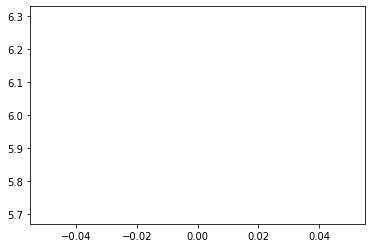

In [26]:
import pyaudio
model = torch.load('./data/model_60epochs.pkl')
model.eval()

import matplotlib.pyplot as plt
words_alphabet = dataset.word_alphabet
slots_alphabet = dataset.slot_alphabet
intent_alphabet = dataset.intent_alphabet

def nlu(words):
    var_text = Variable(torch.LongTensor([words_alphabet.get_index(words)]))
    seq_lens = Variable(torch.LongTensor([len(words)]))
    if torch.cuda.is_available():
        var_text = var_text.cuda()
    slot_idx, intent_idx = model(var_text, seq_lens, n_predicts=1)
    print(intent_idx)
    plt.plot(intent_idx)
    nested_slots = Evaluator.nested_list([list(Evaluator.expand_list(slot_idx))], seq_lens)[0]
    slots = slots_alphabet.get_instance(nested_slots)
    nested_intent = Evaluator.nested_list([list(Evaluator.expand_list(intent_idx))], seq_lens)[0]
    intent = Evaluator.max_freq_predict(nested_intent)
    for i in range(0, len(words)):
        print(words[i], ": \t", slots[0][i])

    print(intent_alphabet.get_instance(intent))

import wave
 
chunk = 1024      # Each chunk will consist of 1024 samples
sample_format = pyaudio.paInt16      # 16 bits per sample
channels = 1      # Number of audio channels
fs = 16000        # Record at 16000 samples per second
time_in_seconds = 3
filename = "./soundsample.wav"
 
p = pyaudio.PyAudio()  # Create an interface to PortAudio
 
print('-----Now Recording-----')
 
#Open a Stream with the values we just defined
stream = p.open(format=sample_format,
                channels = channels,
                rate = fs,
                frames_per_buffer = chunk,
                input = True)
 
frames = []  # Initialize array to store frames
 
# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * time_in_seconds)):
    data = stream.read(chunk)
    frames.append(data)
 
# Stop and close the Stream and PyAudio
stream.stop_stream()
stream.close()
p.terminate()
 
print('-----Finished Recording-----')
 
# Open and Set the data of the WAV file
file = wave.open(filename, 'wb')
file.setnchannels(channels)
file.setsampwidth(p.get_sample_size(sample_format))
file.setframerate(fs)
 
#Write and Close the File
file.writeframes(b''.join(frames))
file.close()

files = ['./soundsample.wav']
for fname, transcription in zip(files, asr_model.transcribe(paths2audio_files=files,num_workers=0)):
    print(f"Audio in {fname} was recognized as: {transcription}")
    nlu(transcription.split(' '))

In [24]:
# duration of signal frame, seconds
FRAME_LEN = 1.0
# number of audio channels (expect mono signal)
CHANNELS = 1

CHUNK_SIZE = int(FRAME_LEN*SAMPLE_RATE)
asr = FrameASR(model_definition = {
                   'sample_rate': SAMPLE_RATE,
                   'AudioToMelSpectrogramPreprocessor': cfg.preprocessor,
                   'JasperEncoder': cfg.encoder,
                   'labels': cfg.decoder.vocabulary
               },
               frame_len=FRAME_LEN, frame_overlap=2, 
               offset=4)

In [50]:
asr.reset()

p = pa.PyAudio()
print('Available audio input devices:')
input_devices = []
for i in range(p.get_device_count()):
    dev = p.get_device_info_by_index(i)
    if dev.get('maxInputChannels'):
        input_devices.append(i)
        print(i, dev.get('name'))

if len(input_devices):
    dev_idx = -2
    while dev_idx not in input_devices:
        print('Please type input device ID:')
        dev_idx = int(input())

    empty_counter = 0
    transcription = ""

    def callback(in_data, frame_count, time_info, status):
        global empty_counter
        global transcription
        signal = np.frombuffer(in_data, dtype=np.int16)
        text = asr.transcribe(signal)
        if len(text):
            print(text,end='')
            transcription = transcription + text
            empty_counter = asr.offset
        elif empty_counter > 0:
            empty_counter -= 1
            if empty_counter == 0:
                print(' ',end='')
                transcription = transcription + ' '
        return (in_data, pa.paContinue)

    stream = p.open(format=pa.paInt16,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    input_device_index=dev_idx,
                    stream_callback=callback,
                    frames_per_buffer=CHUNK_SIZE)

    print('Listening...')

    stream.start_stream()
    
    # Interrupt kernel and then speak for a few more words to exit the pyaudio loop !
    try:
        while stream.is_active():
            time.sleep(0.1)
    finally:        
        stream.stop_stream()
        stream.close()
        p.terminate()

        print()
        print("PyAudio stopped")
        print(transcription)
    
else:
    print('ERROR: No audio input device found.')

Available audio input devices:
0 Built-in Microphone
Please type input device ID:
0
Listening...
hellooh
PyAudio stopped
hellooh


KeyboardInterrupt: 